# VGG19 - Adding Metadata and Using Bounding Boxes

## Imports and Configuration

In [1]:
import sys, os
sys.path.append(os.path.abspath('../util'))

# core imports
from keras_tf_util import *
from keras.applications.vgg19 import VGG19 #, preprocess_input, decode_predictions

Using TensorFlow backend.


In [2]:
# configure various jupyter defaults
%matplotlib notebook
plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# configure autoreload to automatically reload modules when files are changed
%load_ext autoreload
%autoreload 2

## Utility Functions

In [3]:
# preprocess and load image data; will reload data if already preprocessed
def load_img_data(file_path, data_path, target_size=(224,224)):
    if not os.path.exists(file_path):
        d = get_data(data_path, target_size=target_size)
        save_array(file_path, d)
    else:
        d = load_array(file_path)
        print('{0} loaded ...'.format(os.path.basename(file_path)))
        
    return d

# precompute and load precomputed output; will reload data if already precomputed
def load_precomputed_features(file_path, model, data, batch_size=64):
    if not os.path.exists(file_path):
        d = model.predict(data, batch_size=batch_size)
        save_array(file_path, d)
        print('{0} saved ...'.format(os.path.basename(file_path)))
    else:
        d = load_array(file_path)
        print('{0} loaded ...'.format(os.path.basename(file_path)))
        
    return d

## Setup

In [4]:
current_dir = os.getcwd() + '/'
DATA_HOME_DIR = current_dir + 'data/'
use_sample = False

path = DATA_HOME_DIR if not use_sample else DATA_HOME_DIR + 'sample/'

train_path = path + 'train/'
val_path = path + 'valid/'
test_path = DATA_HOME_DIR + 'test_stg1/'

models_path = (current_dir if not use_sample else path) + 'models/'   # save models & weights here
results_path = (current_dir if not use_sample else path) + 'results/' # save predictions here
preprocesed_data_path = path + 'preprocesed_data/'  # save preprocessed data used for training here

if not os.path.exists(models_path): os.makedirs(models_path)
if not os.path.exists(results_path): os.makedirs(results_path)
if not os.path.exists(preprocesed_data_path): os.makedirs(preprocesed_data_path)

In [5]:
bs = 12 #12 works on my ubuntu notebook (64 would be better)

## Preprocess data

In [6]:
# get classes, one-hot encoded labels, and filenames
train_classes, train_labels, train_filenames = get_batch_info(train_path)
val_classes, val_labels, val_filenames = get_batch_info(val_path)
test_filenames = get_batch_info(train_path)[2]

# sometimes helpful to have filenames without the parent folder
raw_train_filenames = [ s.split('/')[-1] for s in train_filenames ]
raw_val_filenames = [ s.split('/')[-1] for s in val_filenames ]
raw_test_filenames = [ s.split('/')[-1] for s in test_filenames ]

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.


In [7]:
# preprocess and load image data; will reload data if already pre-processed    
train_data = load_img_data(preprocesed_data_path + 'train_data.bc', train_path)
val_data = load_img_data(preprocesed_data_path + 'val_data.bc', val_path)
test_data = load_img_data(preprocesed_data_path + 'test_data.bc', test_path)

train_data.bc loaded ...
val_data.bc loaded ...
test_data.bc loaded ...


## Precompute convolutional features

In [24]:
limit_mem()

# you have to specify input_shape IF you want to use with pre-computed datasets!!!
base_model = VGG19(include_top=False, input_shape=(224,224,3))

In [25]:
# base_model.summary()

In [26]:
conv_train_feat = load_precomputed_features(preprocesed_data_path + 'conv_train_feat_vgg19.bc', base_model, train_data, bs)
conv_val_feat = load_precomputed_features(preprocesed_data_path + 'conv_val_feat_vgg19.bc', base_model, val_data, bs)
conv_test_feat = load_precomputed_features(preprocesed_data_path + 'conv_test_feat_vgg19.bc', base_model, test_data, bs)

conv_train_feat_vgg19.bc loaded ...
conv_val_feat_vgg19.bc loaded ...
conv_test_feat_vgg19.bc loaded ...


In [27]:
conv_train_feat.shape

(3277, 7, 7, 512)

In [28]:
base_model.output.shape.as_list()

[None, 7, 7, 512]

## Finetuning Dense Layers

Input will be the convolutional features of VGG, the output of the base model (where "include_top=False")

In [ ]:
def build_vgg19_fc_seq(p):
    # using sequential API
    return [
        BatchNormalization(axis=1, input_shape=base_model.output.shape.as_list()[1:]),
        Dropout(p / 4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p / 2),
        Dense(8, activation='softmax')
    ]

In [ ]:
def build_vgg19_fc_func(p):
    # using functional API
    inputs = Input(shape=base_model.output.shape.as_list()[1:])
    
    x = BatchNormalization(axis=1)(inputs)
    x = Dropout(p / 4)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = Dense(512, activation='relu')(x)
    
    x = BatchNormalization()(x)
    x = Dropout(p / 2)(x)
    preds = Dense(8, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=preds)

In [ ]:
p = 0.6

In [ ]:
limit_mem()

# model = Sequential(build_vgg19_fc_seq(p))
model = build_vgg19_fc_func(p)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(conv_train_feat, train_labels, batch_size=bs, epochs=4, 
          validation_data=(conv_val_feat, val_labels))

In [ ]:
model.optimizer.lr = 1e-4

model.fit(conv_train_feat, train_labels, batch_size=bs, epochs=7, 
          validation_data=(conv_val_feat, val_labels))

In [ ]:
model.save_weights(models_path + '02-vgg19_custom_fc_weights.h5')
# model.load_weights(models_path + '02-vgg19_custom_fc_weights.h5')

## Multi-input

Input will be the convolutional features of VGG, the output of the base model (where "include_top=False").  

Examine if we can take advantage of **data leakage** because "the images are of different sizes, which are likely to represent the boat they cam from"

In [29]:
limit_mem()

# you have to specify input_shape IF you want to use with pre-computed datasets!!!
base_model = VGG19(include_top=False, input_shape=(224,224,3))

In [30]:
img_sizes = [ PIL.Image.open(train_path + f).size for f in train_filenames]

In [31]:
# the unique set of image sizes
id2size = list(set(img_sizes))
size2id = { o:i for i,o in enumerate(id2size) }

In [32]:
import collections
collections.Counter(img_sizes)

Counter({(1192, 670): 170,
         (1244, 700): 25,
         (1276, 718): 196,
         (1280, 720): 1880,
         (1280, 750): 513,
         (1280, 924): 58,
         (1280, 974): 342,
         (1334, 750): 25,
         (1518, 854): 37,
         (1732, 974): 31})

In [58]:
# one-hot encode size data for each image since we want to treat them as categorical
train_size_labels = to_categorical([ size2id[fsz] for fsz in img_sizes ], len(id2size))

val_img_sizes = [ PIL.Image.open(val_path + f).size for f in val_filenames ]
val_size_labels = to_categorical([ size2id[fsz] for fsz in val_img_sizes ], len(id2size))

In [59]:
# normalize the data (BUT why?)
train_size_labels = (train_size_labels - train_size_labels.mean(axis=0)) / train_size_labels.std(axis=0)
val_size_labels = (val_size_labels - train_size_labels.mean(axis=0)) / train_size_labels.std(axis=0)

In [35]:
# train_size_labels[0]

In [42]:
limit_mem()

p = 0.6

inp = Input(shape=base_model.output.shape.as_list()[1:])
sz_inp = Input(shape=(len(id2size),))
bnsz_inp = BatchNormalization()(sz_inp)

x = BatchNormalization(axis=1)(inp)
x = Dropout(p / 4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)

x = BatchNormalization()(x)
x = Dropout(p / 2)(x)
x = concatenate([x, bnsz_inp])
preds = Dense(8, activation='softmax')(x)

model = Model(inputs=[inp, sz_inp], outputs=preds)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
model.fit([conv_train_feat, train_size_labels], train_labels, batch_size=bs, epochs=4, 
          validation_data=([conv_val_feat, val_size_labels], val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/4
3277/3277 [==============================] - 42s - loss: 1.2576 - acc: 0.6228 - val_loss: 0.4641 - val_acc: 0.8460
Epoch 2/4
3277/3277 [==============================] - 42s - loss: 0.5671 - acc: 0.8322 - val_loss: 0.2721 - val_acc: 0.9260
Epoch 3/4
3277/3277 [==============================] - 42s - loss: 0.3390 - acc: 0.8996 - val_loss: 0.1869 - val_acc: 0.9520
Epoch 4/4
3277/3277 [==============================] - 42s - loss: 0.2167 - acc: 0.9262 - val_loss: 0.3042 - val_acc: 0.9560


In [44]:
model.optimizer.lr = 1e-5

model.fit([conv_train_feat, train_size_labels], train_labels, batch_size=bs, epochs=8, 
          validation_data=([conv_val_feat, val_size_labels], val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/8
3277/3277 [==============================] - 42s - loss: 0.1818 - acc: 0.9466 - val_loss: 0.1151 - val_acc: 0.9740
Epoch 2/8
3277/3277 [==============================] - 42s - loss: 0.1827 - acc: 0.9432 - val_loss: 0.1399 - val_acc: 0.9680
Epoch 3/8
3277/3277 [==============================] - 42s - loss: 0.1543 - acc: 0.9500 - val_loss: 0.1758 - val_acc: 0.9660
Epoch 4/8
3277/3277 [==============================] - 43s - loss: 0.1025 - acc: 0.9689 - val_loss: 0.1314 - val_acc: 0.9720
Epoch 5/8
3277/3277 [==============================] - 43s - loss: 0.1025 - acc: 0.9683 - val_loss: 0.1498 - val_acc: 0.9660
Epoch 6/8
3277/3277 [==============================] - 43s - loss: 0.1116 - acc: 0.9625 - val_loss: 0.1309 - val_acc: 0.9700
Epoch 7/8
3277/3277 [==============================] - 43s - loss: 0.0968 - acc: 0.9670 - val_loss: 0.1483 - val_acc: 0.9720
Epoch 8/8
3277/3277 [==============================] - 43s - loss: 0.1103 - ac

In [45]:
model.save_weights(models_path + '02-vgg19_multi-input_weights.h5')
# model.load_weights(models_path + '02-vgg19_custom_fc_weights.h5')

## Bounding Boxes & Multi-Output

Input will be the convolutional features of VGG, the output of the base model (where "include_top=False").  

In [46]:
bb_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [50]:
# get the biggest annotations (some images contain multiple boxes because there are multiple fish)
bb_json = {}
for c in bb_classes:
    j = json.load(open('{}bb_annotations/{}_labels.json'.format(DATA_HOME_DIR, c), 'r'))
    for l in j:
        if('annotations' in l.keys() and len(l['annotations']) > 0):
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width']
            )[-1]

In [51]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [52]:
train_file2idx = { o:i for i,o in enumerate(raw_train_filenames) }
val_file2idx = { o:i for i,o in enumerate(raw_val_filenames) }

In [54]:
# for any images that have no annotations, we'll create an empty bounding box
empty_bbox = { 'height': 0., 'width': 0., 'x': 0., 'y': 0. }

for f in raw_train_filenames:
    if (f not in bb_json.keys()): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if (f not in bb_json.keys()): bb_json[f] = empty_bbox

In [55]:
# convert dictionary to array and convert the coordinates to our resized 224x224 image
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [ bb[p] for p in bb_params ]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0] * conv_y
    bb[1] = bb[1] * conv_x
    bb[2] = max(bb[2] * conv_x, 0)
    bb[3] = max(bb[3] * conv_y, 0)
    
    return bb

In [62]:
train_bbox = [ convert_bb(bb_json[f], s) for f,s in zip(raw_train_filenames, img_sizes) ]
train_bbox = np.stack(train_bbox).astype(np.float32)

val_bbox = [ convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, val_img_sizes) ]
val_bbox = np.stack(val_bbox).astype(np.float32)

train_bbox.shape, val_bbox.shape

((3277, 4), (500, 4))

In [80]:
# check our work by drawing one of the annotations
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plt.imshow(val_data[i].astype(np.uint8))
    plt.gca().add_patch(create_rect(bb))

<IPython.core.display.Javascript object>


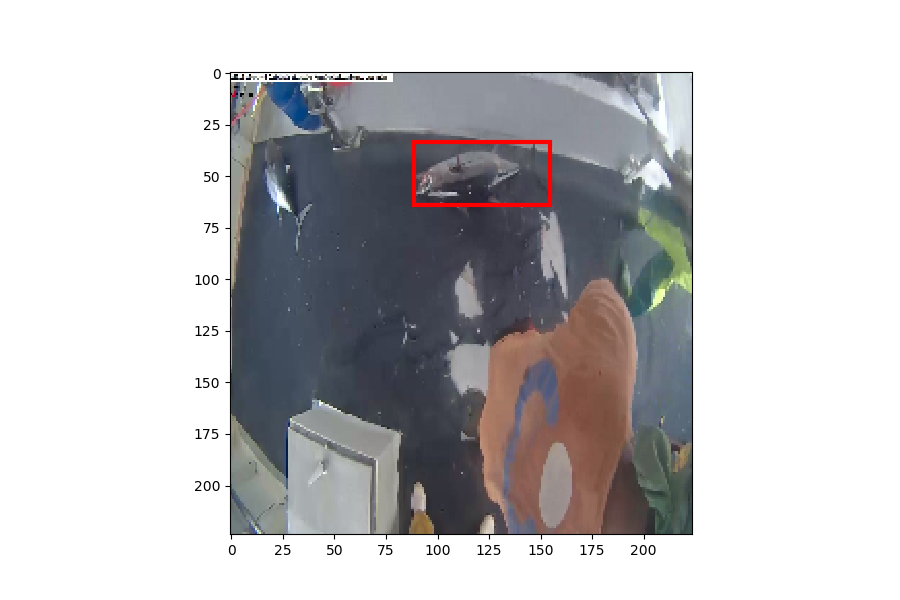

In [88]:
show_bb(50)

In [91]:
# create and train model with multiple outputs that predicts both the type of fish (the 'class') and
# the 4 bounding box coordinates

limit_mem()

p = 0.6

inp = Input(shape=base_model.output.shape.as_list()[1:])
x = BatchNormalization(axis=1)(inp)
x = Dropout(p / 4)(x)
x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p / 2)(x)

bb_preds = Dense(4, name='bb')(x)
class_preds = Dense(8, activation='softmax', name='class')(x)


In [92]:
# for multi-ouput we need to specify what loss function to use for each and "we also weight
# the bounding-box loss function down by 1000x since the scale of cross-entropy loss and MSE is very different
model = Model(inputs=[inp], outputs=[bb_preds, class_preds])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[0.001, 1.])

In [93]:
model.fit(conv_train_feat, [train_bbox, train_labels], batch_size=bs, epochs=3, 
          validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 43s - loss: 5.9637 - bb_loss: 4707.9409 - class_loss: 1.2557 - bb_acc: 0.4397 - class_acc: 0.6396 - val_loss: 4.5453 - val_bb_loss: 4180.5317 - val_class_loss: 0.3648 - val_bb_acc: 0.5180 - val_class_acc: 0.8860
Epoch 2/3
3277/3277 [==============================] - 43s - loss: 3.3990 - bb_loss: 2873.4099 - class_loss: 0.5256 - bb_acc: 0.5578 - class_acc: 0.8392 - val_loss: 1.9554 - val_bb_loss: 1749.9523 - val_class_loss: 0.2054 - val_bb_acc: 0.6100 - val_class_acc: 0.9520
Epoch 3/3
3277/3277 [==============================] - 43s - loss: 1.2544 - bb_loss: 919.5638 - class_loss: 0.3349 - bb_acc: 0.6689 - class_acc: 0.8914 - val_loss: 0.7796 - val_bb_loss: 584.4418 - val_class_loss: 0.1952 - val_bb_acc: 0.7120 - val_class_acc: 0.9540


In [94]:
model.optimizer.lr = 1e-5

model.fit(conv_train_feat, [train_bbox, train_labels], batch_size=bs, epochs=10, 
          validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 43s - loss: 0.8241 - bb_loss: 566.5888 - class_loss: 0.2575 - bb_acc: 0.6881 - class_acc: 0.9152 - val_loss: 0.6983 - val_bb_loss: 484.4711 - val_class_loss: 0.2138 - val_bb_acc: 0.7500 - val_class_acc: 0.9380
Epoch 2/10
3277/3277 [==============================] - 43s - loss: 0.6963 - bb_loss: 501.2193 - class_loss: 0.1950 - bb_acc: 0.7025 - class_acc: 0.9384 - val_loss: 0.5523 - val_bb_loss: 414.2914 - val_class_loss: 0.1381 - val_bb_acc: 0.7660 - val_class_acc: 0.9700
Epoch 3/10
3277/3277 [==============================] - 43s - loss: 0.6242 - bb_loss: 468.9437 - class_loss: 0.1552 - bb_acc: 0.6988 - class_acc: 0.9448 - val_loss: 0.5342 - val_bb_loss: 371.0741 - val_class_loss: 0.1632 - val_bb_acc: 0.7740 - val_class_acc: 0.9480
Epoch 4/10
3277/3277 [==============================] - 43s - loss: 0.5947 - bb_loss: 437.6908 - class_loss: 0.1570 - bb_acc: 0.7156 - class_acc: 0.9503 - 

In [95]:
# get the first 10 predictions
preds = model.predict(conv_val_feat[:10])

In [104]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = preds[0][i]
    
    plt.figure(figsize=(8,8))
    plt.imshow(val_data[i].astype(np.uint8))
    
    ax = plt.gca()
    ax.add_patch(create_rect(bb_pred, color='yellow'))
    ax.add_patch(create_rect(bb))

<IPython.core.display.Javascript object>


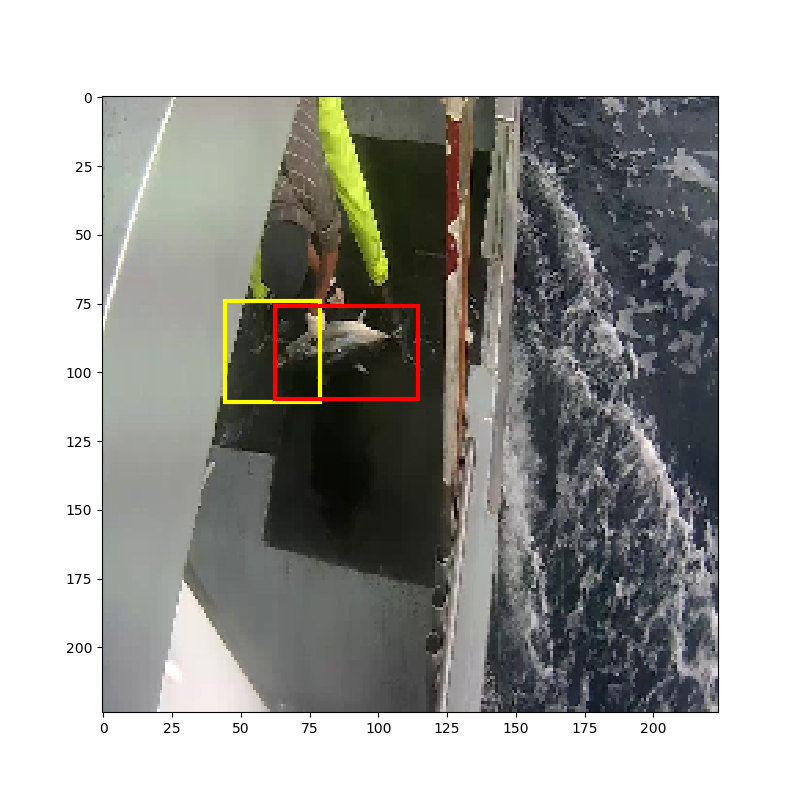

In [110]:
show_bb_pred(2)

In [106]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

500/500 [==============================] - 1s     


[1.7895979185104369,
 1650.1728569335937,
 0.13942498419061303,
 0.78599999904632567,
 0.97799999999999998]

In [107]:
model.save_weights(models_path + '02-vgg19_multi-output_bb_weights.h5')
# model.load_weights(models_path + '02-vgg19_multi-output_bb_weights.h5')